## 04 EEG Image Reconstruction

In [1]:
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *

import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import os
import random
import warnings
warnings.filterwarnings("ignore")

from IPython.display import clear_output
%matplotlib inline
from chosen_gpu import get_freer_gpu

#### Check GPU availability

In [2]:
device = torch.device(get_freer_gpu()) 
print("Configured device: ", device)

Configured device:  cuda:0


### Define stuffs

In [3]:
par = "par1"
file = "1-Chaichan_1_2021-04-07-06.24.14" 
task = "_visual"
model_name = "cnn"
drift = "drift"

### 1. Load Data
***

#### 1.1 Load Stimulus Data

* 1 = Red
* 2 = Green
* 3 = Blue

In [4]:
batch_size = 3 # ideal batch size ranges from 32 to 128
image_size = 28
img_nc     = 1

trsfm = transforms.Compose([transforms.Resize(image_size), 
                            transforms.CenterCrop(image_size),
                            transforms.ToTensor()])

from PIL import Image
real_images_fabby = torch.zeros((3,3,28,28))
# print(real_images_fabby[0].shape)

red = Image.open('../2-HCI_stimuli/stimulus/cylinder/R/1.png')
red = trsfm(red.convert('RGB'))
green = Image.open('../2-HCI_stimuli/stimulus/cylinder/G/2.png')
green = trsfm(green.convert('RGB'))
blue = Image.open('../2-HCI_stimuli/stimulus/cylinder/B/3.png')
blue = trsfm(blue.convert('RGB'))

real_images_fabby[0] = red
real_images_fabby[1] = green
real_images_fabby[2] = blue
real_images = real_images_fabby
print(real_images.shape)

actual_y = [0,1,2]
actual_y = torch.Tensor(actual_y).long()
print(actual_y)

torch.Size([3, 3, 28, 28])
tensor([0, 1, 2])


#### 1.2 Load the latent EEG features and y labels


In [7]:
# EEG_latent = np.load('../weights/HCI/EEG_feature/par1_X.npy')
# y          = np.load('../weights/HCI/EEG_feature/par1_y.npy')
EEG_latent = np.load('../data/extracted_features/round2/{par}/{file}{task}_X.npy'.format(par=par,file=file,task=task))
y          = np.load('../data/extracted_features/round2/{par}/{file}{task}_y.npy'.format(par=par,file=file,task=task))

print("Shape of EEG_latent: ",EEG_latent.shape)
print("y: ",y[:20])

Shape of EEG_latent:  (540, 32)
y:  [2 2 2 2 2 2 2 2 0 0 0 0 1 1 1 1 0 0 0 0]


##### 1.2.1 Convert to torch

In [8]:
torch_X = torch.from_numpy(EEG_latent)
torch_y = torch.from_numpy(y)
print("Shape of torch_X: ", torch_X.shape)
print("Shape of torch_y: ", torch_y.shape)
# print(torch_y)

Shape of torch_X:  torch.Size([540, 32])
Shape of torch_y:  torch.Size([540])


##### 1.2.2 Dataloader

In [9]:
ds = TensorDataset(torch_X, torch_y)

latent_loader = DataLoader(ds,
                batch_size = batch_size,
                drop_last  = True, # Drop the last batch if it is not enough for the batch size
                shuffle    = True,
                pin_memory = True) # True = copy Tensors into CUDA pinned memory before returning them

In [10]:
dataiter        = iter(latent_loader)
latents, labels = dataiter.next()
print("number of batches: ",len(latent_loader))
print("Shape of latents: ",latents.shape)
print("Shape of labels: ",labels.shape)

number of batches:  180
Shape of latents:  torch.Size([3, 32])
Shape of labels:  torch.Size([3])


### 2. Define Model
***

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import fnmatch

In [12]:
class Generator(nn.Module):
    """
    Input : random noise / latent vector of any size
    Output : Fake images same size as Real images 
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        
        self.activation = nn.LeakyReLU()
        
        self.fc1 = nn.Sequential (nn.Linear(input_size    , hidden_size )  , self.activation, nn.Dropout(0.3) )
        self.fc2 = nn.Sequential (nn.Linear(hidden_size   , hidden_size*2) , self.activation, nn.Dropout(0.3) )
        self.fc3 = nn.Sequential (nn.Linear(hidden_size*2 , hidden_size*4) , self.activation, nn.Dropout(0.3) )
        self.fc4 = nn.Sequential (nn.Linear(hidden_size*4 , output_size )  , self.activation                  )    
    
    def forward(self, X, noise):
#         print('GENERATOR')
        X = torch.cat([X, noise], dim = 1)
        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        X = self.fc4(X)
        X = X.reshape(-1, 3, 28, 28)
        
        return X
    
class Discriminator(nn.Module):
    """
    Input : Real / Fake images
    Output : Classification Real = 1 / Fake = 0
    """
    def __init__(self, input_size, hidden_size):
        super(Discriminator, self).__init__()
        
        self.activation = nn.LeakyReLU()
        
        self.fc1 = nn.Sequential (nn.Linear(input_size, hidden_size*6)      , self.activation, nn.Dropout(0.3))
        self.fc2 = nn.Sequential (nn.Linear(hidden_size*6, hidden_size*4)   , self.activation, nn.Dropout(0.3))
        self.fc3 = nn.Sequential (nn.Linear(hidden_size*4, hidden_size*2)   , self.activation  , nn.Dropout(0.3))
        self.fc4 = nn.Sequential (nn.Linear((hidden_size*2)+32, hidden_size), self.activation  , nn.Dropout(0.3))
        
        self.fc5_0 = nn.Sequential (nn.Linear(hidden_size, 32), self.activation  , nn.Dropout(0.3) )  # for real / fake
        self.fc5_1 = nn.Sequential (nn.Linear(32, 16), self.activation  , nn.Dropout(0.3) )
        self.fc5_2 = nn.Sequential (nn.Linear(16, 8),self.activation  , nn.Dropout(0.3)  ) 
        self.fc5_3 = nn.Sequential (nn.Linear(8, 1)  )
        
        self.fc6_0 = nn.Sequential (nn.Linear(hidden_size, 32) , self.activation  , nn.Dropout(0.3)  ) # for number classification
        self.fc6_1 = nn.Sequential (nn.Linear(32, 3) )
    
    def forward(self, X, latent):
#         print('DISCRIMINATOR')
               
        X = X.flatten(start_dim = 1)

        X = self.fc1(X)
        X = self.fc2(X)
        X = self.fc3(X)
        X = torch.cat([X, latent], dim = 1)                          
        X = self.fc4(X)
        
        rf_decision = self.fc5_0(X)
        rf_decision = self.fc5_1(rf_decision)
        rf_decision = self.fc5_2(rf_decision)
        rf_decision = self.fc5_3(rf_decision)
        
        num_decision = self.fc6_0(X)
        num_decision = self.fc6_1(num_decision)
        
        return rf_decision, num_decision

In [13]:
def do_plot(d_losses, g_losses):
    plt.figure(figsize=(25,5))
#     clear_output(wait=True)
    plt.plot(d_losses, label='Discriminator')
    plt.plot(g_losses, label='Generator')
    plt.title('GAN loss')
    plt.legend()
    plt.show()
    
def random_2D_noise(m,n):
    """
    Random an 2d array of random noise
    =======================
    m = # of samples
    n = # of features
    """
#     mu    = 0 
#     sigma = 1
#     z     = np.random.normal(mu, sigma , size=[m,n])
    z     = np.random.uniform(-1, 1, size=(m,n))
    z     = torch.from_numpy(z).float()
#     z     = z.to(device)
    return z

#### 2.1 Test Generator and discriminator

In [14]:
G_net = Generator(input_size = 48, hidden_size = 96 , output_size = 2352).to(device)

noise_size = 16
noise = random_2D_noise(batch_size, noise_size)
noise = noise.to(device)
fake_img = G_net(latents.to(device), noise)

print("Shape of noise: ",noise.shape)
print("Shape of fake_img: ",fake_img.shape)

Shape of noise:  torch.Size([3, 16])
Shape of fake_img:  torch.Size([3, 3, 28, 28])


In [15]:
D_net = Discriminator(input_size = 2352, hidden_size = 64).to(device)

rf_decision_fake, num_decision_fake = D_net(fake_img, latents.to(device))
print("Shape of rf_decision_fake: ",rf_decision_fake.shape) # r/f
print("Shape of num_decision_fake: ",num_decision_fake.shape) # which class

rf_decision_real, num_decision_real = D_net(real_images.to(device), latents.to(device) )
print("Shape of rf_decision_real: ",rf_decision_real.shape) # r/f
print("Shape of num_decision_real: ",num_decision_real.shape) # which class

Shape of rf_decision_fake:  torch.Size([3, 1])
Shape of num_decision_fake:  torch.Size([3, 3])
Shape of rf_decision_real:  torch.Size([3, 1])
Shape of num_decision_real:  torch.Size([3, 3])


### 3. Training Parameters 
***

#### 3.1 Models

In [16]:
G_net = Generator(input_size = 48, hidden_size = 96 , output_size = 2352).to(device)
D_net = Discriminator(input_size = 2352, hidden_size = 64).to(device)

#### 3.2 Optimizers

In [17]:
lr = 0.0002
G_optimizer = torch.optim.Adam(G_net.parameters(), lr=lr)
D_optimizer = torch.optim.Adam(D_net.parameters(), lr=lr)
                 
gamma = 0.5
G_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(G_optimizer, gamma=gamma)
D_lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(D_optimizer, gamma=gamma)

#### 3.3 Loss functions

In [18]:
BCE_loss_criterion = nn.BCEWithLogitsLoss().to(device) # use with rf_decision
d_classify_criterion = nn.CrossEntropyLoss().to(device) # use with num_decision
lamda = 0.01
semantic_criterion = nn.MSELoss().to(device)

#### 3.4 Epochs

In [19]:
# Number of iterations
NUM_EPOCH   = 100       ## > 50 epoch
print_every = 400
g_best_valid_loss = float('inf')
d_best_valid_loss = float('inf')

#### 3.5 Plots

In [20]:
# For plotting
d_losses    = []
g_losses    = []

g_recon_image_list   = []
eeg_original_labels  = []
gd_class_decision_from_fake_image_list = []
# samples_z = []

# fixed_latent = []
# for i in range(10):
#     temp = latent[torch_y==i]
#     fixed_latent.append(temp)

# fixed_latent = np.array(fixed_latent[0].cpu())
# fixed_latent = torch.from_numpy(fixed_latent).to(device).squeeze()
# fixed_noise = create2D_noise(10, 100) # create 10 noise to check the model performance

#### 3.6 Noise

In [21]:
noise_size = 16
noise_size_latent = 32

## 6. Train

Epoch : 100/100 | Iteration : 17821 | d_loss: 0.000520 | g_loss: 9.382560


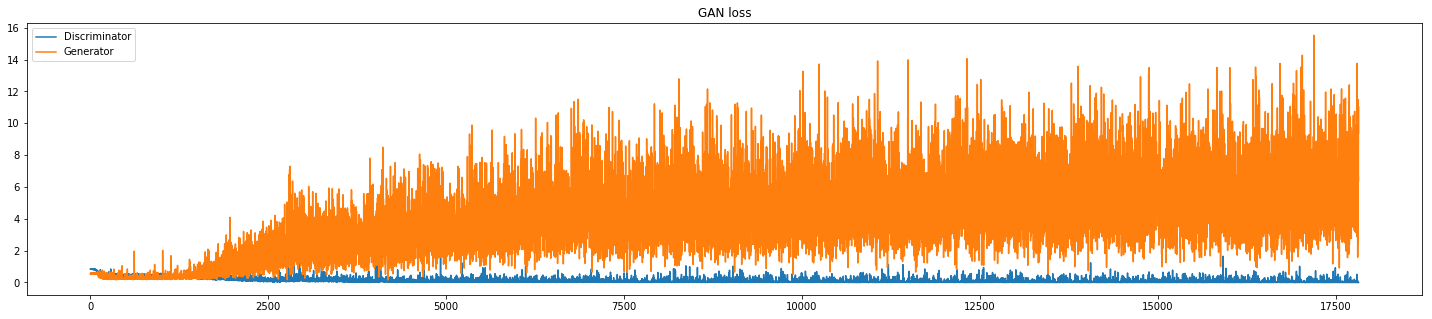

In [22]:
# set G and D in TRAIN MODE ( DO dropout )
G_net.train()
D_net.train()
# noise_latent = random_2D_noise(batch_size, 32)
# zero_latent = torch.from_numpy(np.zeros((batch_size,32) )).to(device).float()

iteration = 0
for epoch in range(NUM_EPOCH):
    
    for batch_i , (eeg_latent, labels ) in enumerate(latent_loader):
        
        G_net.train()
        D_net.train()
        
        # ======== TRAIN DISCRIMINATOR ===========
        D_net.zero_grad()
        G_net.zero_grad()
        D_optimizer.zero_grad()
        
        eeg_latent = eeg_latent.to(device)
        labels     = labels.to(device)
       
        #---------- create all noises -------
        noise_latent = random_2D_noise(batch_size, noise_size_latent)
        noise_latent = noise_latent.to(device)

        noise_d = random_2D_noise(batch_size, noise_size)
        noise_d = noise_d.to(device)

        noise_g = random_2D_noise(batch_size, noise_size)
        noise_g = noise_g.to(device)
        
        #---------- Train with real image -------
        real_images = real_images.to(device)
        actual_y = actual_y.to(device)
        
        #rf_decision_real_image, num_decision_real_image = D_net(real_images, noise_latent)   
        d_decision_out, d_class_out = D_net(real_images, noise_latent)   
        all_real_labels = torch.from_numpy(np.ones(d_decision_out.shape)).to(device)
        
        d_loss_with_real_img = BCE_loss_criterion( d_decision_out  ,  all_real_labels  )
        d_classify_loss = d_classify_criterion(     d_class_out  ,    actual_y         )
        
        
        #---------- Train with fake image -------
        d_recon_image = G_net(eeg_latent, noise_d)
        d_decision_out, d_class_out = D_net(d_recon_image, eeg_latent) 
        all_fake_labels = torch.from_numpy(np.zeros(d_decision_out.shape)).to(device)
        
        d_loss_with_fake_img  = BCE_loss_criterion(d_decision_out, all_fake_labels)
        d_loss = (d_loss_with_real_img + d_classify_loss + d_loss_with_fake_img)/3
        
        d_loss.backward()
        D_optimizer.step()
#         D_lr_scheduler.step()  
        
        d_losses.append(d_loss.item())
    
        # ======== TRAIN GENERATOR ===========
        D_net.zero_grad()
        G_net.zero_grad()  
        G_optimizer.zero_grad()
        
        G_recon_image = G_net(eeg_latent, noise_g)
        gd_decision_out, gd_class_decision_from_fake_image = D_net(G_recon_image , eeg_latent)
        gd_class_decision_from_fake_image_list.append(gd_class_decision_from_fake_image)
        
        all_real_labels = torch.from_numpy(np.ones(gd_decision_out.shape)).to(device)
        
#         print('labels: ',labels)
# #         print('actual_y: ',actual_y)
        
        semantic_loss = semantic_criterion(G_recon_image, real_images[labels])
        gd_fake_rf_loss = BCE_loss_criterion(gd_decision_out, all_real_labels)
        gd_fake_num_loss= d_classify_criterion(gd_class_decision_from_fake_image, labels)
        
        g_loss = (gd_fake_rf_loss + gd_fake_num_loss + (lamda*semantic_loss))/3

#         g_loss = (gd_fake_rf_loss + gd_fake_num_loss)/3
        g_loss.backward()
        G_optimizer.step()
#         G_lr_scheduler.step()
        
        g_losses.append(g_loss.item())
        eeg_original_labels.append(labels)
        g_recon_image_list.append(G_recon_image)
        
        iteration     += 1
        
        #--------- Display loss---------
        if batch_i % print_every == 0:
            clear_output(wait=True)
            print('Epoch : {:1d}/{:1d} | Iteration : {:1d} | d_loss: {:6.6f} | g_loss: {:6.6f}'.format(epoch+1, NUM_EPOCH, iteration, d_loss.item(), g_loss.item()))
            do_plot(d_losses, g_losses)

        #------- Save Discriminator ------     
        if d_loss < d_best_valid_loss:
            d_best_valid_loss = d_loss
            print("Discriminator saved.")
            torch.save(D_net.state_dict(), "../model/our_GAN/round2/{par}/{model_name}/{drift}/DISCRIMINATOR{task}.pt.tar".format(par=par, model_name=model_name,drift=drift,task=task))
#             d_best_valid_loss = i
        
        #--------- Save Generator ---------   
        if g_loss < g_best_valid_loss:
            g_best_valid_loss = g_loss
            print("Generator saved.")
            torch.save(G_net.state_dict(), "../model/our_GAN/round2/{par}/{model_name}/{drift}/GENERATOR{task}.pt.tar".format(par=par, model_name=model_name,drift=drift,task=task))
#             g_best_valid_loss = i  

In [23]:
# print(G_recon_image[-1,0].shape)

# plt.imshow(G_recon_image[-2,0].cpu().detach().numpy())

# print(torch.max(gd_class_decision_from_fake_image_list[-1],dim=1)[1])


# torch.save(G_net.state_dict(), 'save/Generator_dict_0.5s.tar')
# torch.save(D_net.state_dict(), 'save/Discriminator_dict_0.5s.tar')

### 7. Display stim reconstruct of last batch
***

18000
Y oringinal tensor([2, 1, 1], device='cuda:0')
Y predicted tensor([2, 1, 1], device='cuda:0')
Generated image of last batch


(-0.5, 83.5, 27.5, -0.5)

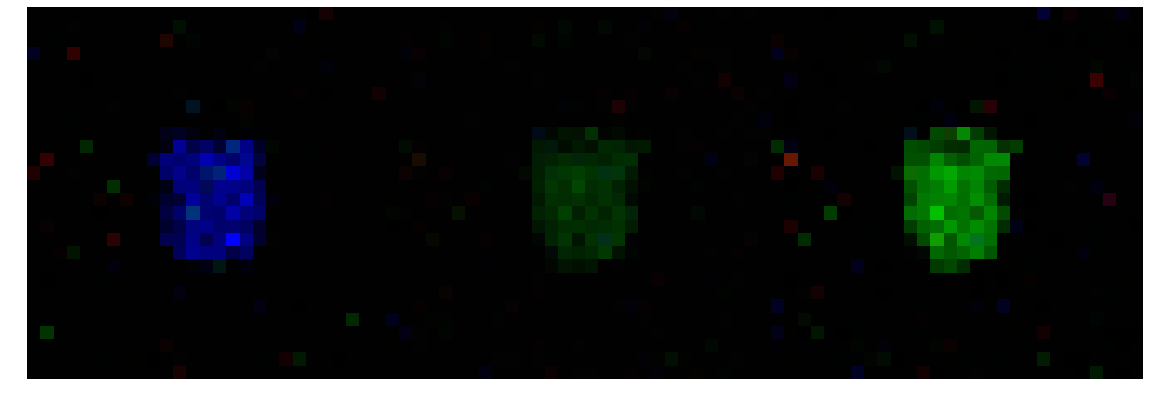

In [24]:
## Display stim reconstruct of last batch

from torchvision.utils import make_grid
from termcolor import colored


print(len(g_recon_image_list))

batch_to_display = 1

images = g_recon_image_list[-batch_to_display]
images = images.cpu()
images = images.reshape(-1, 3, 28, 28)
print(f'Y oringinal {eeg_original_labels[-batch_to_display]}')
print(f'Y predicted {torch.max(gd_class_decision_from_fake_image_list[-batch_to_display],dim=1)[1]}')
print(colored("Generated image of last batch","blue", attrs=['bold']))
grid     = make_grid(images, nrow=10, normalize=True, padding=0)
fig, ax = plt.subplots(figsize=(20,100))
ax.imshow(grid.permute(1, 2, 0).data)
ax.axis('off')

### 8. Evaluate
***
Test pipline:

eeg_test_set --> encoder--> latent --> Generator --> reconstructed_image --> Discriminator --> h_hat (class) --> calculate accuracy

In [25]:
class EEGEncoder(nn.Module):
    '''
    Expected Input Shape: (batch, channels, height , width)
    '''
    def __init__(self):
        super().__init__()
        
        self.activation = nn.Tanh()
        
        self.conv1 = nn.Sequential(    nn.Conv1d(16, 32, kernel_size=(1,3),   padding=(0,0), stride=(1,1))  ,  self.activation )
        self.conv2 = nn.Sequential(    nn.Conv1d(32, 64, kernel_size=(1,3) ,  padding=(0,0), stride=(1,1))  ,  self.activation )
        # nn.Linear(XY,256) need to be changed!
        self.fc1   = nn.Sequential(    nn.Linear(384,256),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(256)   )
        self.fc2   = nn.Sequential(    nn.Linear(256,128),  self.activation ,nn.Dropout(0.1)   ,nn.BatchNorm1d(128) )
        self.fc3   = nn.Sequential(    nn.Linear(128,64),  self.activation  ,nn.Dropout(0.1)   ,nn.BatchNorm1d(64) )
        self.fc4   = nn.Sequential(    nn.Linear(64,32),  self.activation   ,nn.Dropout(0.1)   ,nn.BatchNorm1d(32) )
        self.fc5   = nn.Sequential(    nn.Linear(32,3)   )

        
        
    
        self.is_debug= False
        
    def encode(self, X):
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)

        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc5(X)
        if self.is_debug  : print(X.shape)          
        return X
        
    def forward(self,X):
        X = self.encode(X)
        return X
    
    def get_latent( self, X):
        if self.is_debug  : print('--------Convolute--------'); print(X.shape) 
            
        X = self.conv1(X)
        if self.is_debug  : print(X.shape) 
            
        X = self.conv2(X)
        if self.is_debug  : print(X.shape) 
            
        X = X.flatten(start_dim = 1)
        if self.is_debug  : print('--------Flatten--------') ; print(X.shape) 
 
        X = self.fc1(X)
        if self.is_debug : print('--------Flatten--------') ; print(X.shape) 

        X = self.fc2(X)
        if self.is_debug  : print(X.shape) 

        X = self.fc3(X)
        if self.is_debug  : print(X.shape) 
        
        X = self.fc4(X)
        if self.is_debug  : print(X.shape) 
        
        return X
    
    def classifier(self, latent):
        return self.fc5(latent)

In [26]:
### load X_test, labels
# X_test            = torch.load('save/eeg_X_test_0.5.pt.tar')
X_test_np = np.load('../data/real_test_np/{par}/X_test{task}.npy'.format(par=par,task=task))
y_test_np = np.load('../data/real_test_np/{par}/y_test{task}.npy'.format(par=par,task=task))
X_test = torch.from_numpy(X_test_np)
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1,X_test.shape[2])
y_test = torch.from_numpy(y_test_np)
ds = TensorDataset(X_test_reshaped, y_test)
real_test_loader = torch.utils.data.DataLoader(ds, batch_size=6)
itertest = iter(real_test_loader)
eeg_X_test , labels = itertest.next()
eeg_X_test = eeg_X_test.to(device).float()
labels     = labels.to(device)

In [27]:
### Feed eeg to encoder
# model_eeg_encoder = torch.load('save/model_EEGEncoder_network_0.5s.pt.tar').to(device)
model_eeg_encoder = EEGEncoder()
model_eeg_encoder.load_state_dict(torch.load('../model/feature_extraction/round2/{par}/{model_name}/{drift}/EEG_ENCODER{task}.pt.tar'.format(par=par,model_name=model_name,drift=drift,task=task)))#.to(device)
model_eeg_encoder.eval().to(device)
X_test_latent     = model_eeg_encoder.get_latent(eeg_X_test)

In [28]:
### Feed latent to Generator
G_net_test       = Generator(input_size = 48, hidden_size = 96, output_size = 2352).to(device)
G_net_test.eval()
noise            = random_2D_noise(X_test_latent.shape[0], noise_size)
noise = noise.to(device)
G_net_test.eval()
G_net_test.load_state_dict(torch.load('../model/our_GAN/round2/{par}/{model_name}/{drift}/GENERATOR{task}.pt.tar'.format(par=par,model_name=model_name,drift=drift,task=task)))
g_imag_recon     = G_net_test(X_test_latent, noise)


In [29]:

#### Feed image reconstruction to discriminator
D_net_test      = Discriminator(input_size = 2352, hidden_size = 64 ).to(device)
D_net_test.eval()
D_net_test.load_state_dict(torch.load('../model/our_GAN/round2/{par}/{model_name}/{drift}/DISCRIMINATOR{task}.pt.tar'.format(par=par,model_name=model_name,drift=drift,task=task)))
d_test_decision , d_class_decision_from_fake_image = D_net(g_imag_recon , X_test_latent)


In [30]:
# Generator Cheating score
sigmoid        = nn.Sigmoid()
decision       = torch.round(sigmoid(d_test_decision))
decision       = decision.cpu().detach().numpy()
generator_won  = np.count_nonzero(decision)*100/decision.shape[0]
print(f'Generator won scrore  :\t {generator_won:4.4f} %')


Generator won scrore  :	 0.0000 %


In [31]:
# Accuracy of class decision
LogSoftMax     = nn.LogSoftmax()
d_class        = LogSoftMax(d_class_decision_from_fake_image)
_ , d_class    = torch.max(d_class, dim=1)
class_correct  = (d_class == labels).sum().item()  #.item() give the raw number
class_acc      = 100 * (class_correct / len(labels))
print(f'Classifier accuracy   :\t {class_acc:4.4f} %')

Classifier accuracy   :	 50.0000 %


In [32]:
torch.cuda.empty_cache()